# Generating a bifurcation plot

## Basics

In this notebook we will demonstrate how you can produce a numerically generated bifurcation plot, that does not require analytical insight into the system. In this first chapter we walk you step by step through the basic functions used to generate the data of the bifurcation plot. This will make it easier for you to understand the long script in the second chapter.

First, let's import all modules and functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.linalg import eig

We will explain what the two new functions `root()` and `eig()` do. But first we define our physical system. We use the three-level laser model from sheet 2 (where you actually *do* have analytical solutions):

\begin{align}
\dot{n} & = -n+n\Delta \\
\dot{\Delta} & = p - b\Delta -2n\Delta
\end{align}

In [2]:
# n = y[0]
# Δ = y[1]

def laser(y,t,p,b):
    dndt = -y[0] + y[0]*y[1]
    dDdt = p - b*y[1] - 2*y[0]*y[1]
    return [dndt, dDdt] 

We also define the systems jacobian for better performance during root finding and for stability analysis. If you do not know the jacobian you can use a suitable finite differencing scheme for approximating it.

SciPy functions like `root()` also generate an approximation, albeit in a quite unwieldy form.

In [3]:
def laser_jac(y,t,p,b):
    dndn = -1 + y[1]
    dndd = y[0]
    dddn = -2*y[1]
    dddd = -b-2*y[0]
    
    return np.array([[dndn,dndd],[dddn,dddd]])

Generate a phase portrait to get our bearings:

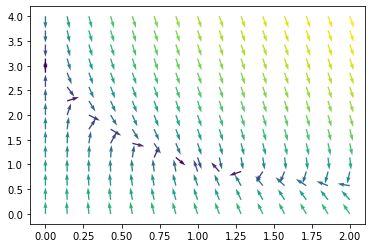

In [4]:
p = 3
b = 1

samples = 15

n = np.linspace(0, 2, samples)
d = np.linspace( 0, 4, samples)
N,D = np.meshgrid(n, d)

DN,DD = laser([N,D], 0, p, b)
nrm = np.sqrt(DN**2 + DD**2)

plt.quiver(N, D, DN/nrm, DD/nrm, np.log(nrm))

If you've worked through exercise sheet 2 you know that there are two fixed points in this phase space. We can use `root()` to search for them. `root` receives the function in question, an initial guess, an optional jacobian and the arguments to actually run the function. It then uses a variation (if not specified otherwise) on Powell's conjugate direction method to search for a nearby root:

In [5]:
sol1 = root(laser, [0,3], jac = laser_jac, args=(0,p,b))

print(sol1)

    fjac: array([[-0.31622777,  0.9486833 ],
       [-0.9486833 , -0.31622777]])
     fun: array([0., 0.])
 message: 'The solution converged.'
    nfev: 2
    njev: 1
     qtf: array([0., 0.])
       r: array([-6.32455532, -0.9486833 ,  0.31622777])
  status: 1
 success: True
       x: array([0., 3.])


As you can see, the returned object contains detailed information about the result. Most important for us is the actually root `x` and the `success` flag:

In [6]:
print("Search successful: ", sol1.success)
print(sol1.x)

Search successful:  True
[0. 3.]


If we chose another initial guess, the search converges to another root:

In [7]:
sol2 = root(laser, [1,1], jac = laser_jac, args=(0,p,b))
print("Search successful: ", sol2.success)
print(sol2.x)

Search successful:  True
[1. 1.]


You can use `scatter` to draw single points in your plot. Notice the use of the *unpack operator* `*`. If you use the asterisk in a function call, the list is *unpacked* as individual arguments. That means that `f(*sol1.x)` is equivalent to `f(sol1.x[0], sol1.x[1])`.

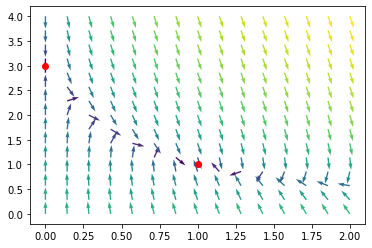

In [8]:
plt.quiver(N, D, DN/nrm, DD/nrm, np.log(nrm))
plt.scatter(*sol1.x, c='r')
plt.scatter(*sol2.x, c='r')

With `eig()` you can calculate eigenvalues and eigenvectors of matrices. For determining the stability we look a the eigenvalues of the jacobians at the fixed points:

In [9]:
jac1 = laser_jac(sol1.x, 0, p, b)
jac2 = laser_jac(sol2.x, 0, p, b)

ev1, evec1 = eig(jac1)
ev2, evec2 = eig(jac2)

print("ev1: ", ev1)
print("ev2: ", ev2)

ev1:  [-1.+0.j  2.+0.j]
ev2:  [-1.+0.j -2.+0.j]


Stability is determined by the real component of the eigenvalues:

In [10]:
print("real(ev1): ", np.real(ev1))
print("real(ev2): ", np.real(ev2))

real(ev1):  [-1.  2.]
real(ev2):  [-1. -2.]


You can use logical expressions on NumPy arrays to get a logical array:

In [11]:
print("real(ev1) < 0: ", np.real(ev1) < 0)
print("real(ev2) < 0: ", np.real(ev2) < 0)

real(ev1) < 0:  [ True False]
real(ev2) < 0:  [ True  True]


Stability requires *all* eigenvalues to have negative real components. Use the command `all()` to use a logical *and* on all elements of a list:

In [12]:
print("FP1 stable: ", all(np.real(ev1) < 0))
print("FP2 stable: ", all(np.real(ev2) < 0))

FP1 stable:  False
FP2 stable:  True


## The complete bifurcation diagram

You've now seen all functions we need to calculate fixed points and their stability. In the last step, we calculate the systems fixed points and their properties for many different values of *p*.

For each p, we generate a big mesh of initial conditions and converge them to local roots. We use numerical rounding and NumPy's `unique()` function to determine how many unique roots have been found by our mesh.We expect to find exactly two fixed points in our model system, but in general you might not know how many there are or where to find them.

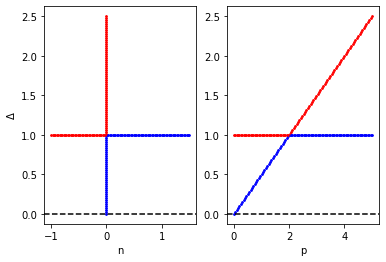

In [13]:
# Create two plots side by side. ax is a list of axes
fig, ax = plt.subplots(1,2)

# Set decay rate
b = 2

# We use (root_samples)^2 sample points as initial conditions for the root finder
root_samples = 4

# Generate a mesh of initial conditions in phase space
n = np.linspace(-3, 3, root_samples)
d = np.linspace( -3, 3, root_samples)
N,D = np.meshgrid(n, d)

# Iterate through phase space. No need for vectorization, the root finder does the hard work
for p in np.linspace(0,5,100):
    
    # Here we collect our stable and unstable roots
    stable_roots = []
    unstbl_roots = []

    # Iterate through our sample mesh
    for n_current,D_current in np.nditer([N,D]):
        
        # Use current sample point and search for a solution
        sol = root(laser, [n_current,D_current], jac = laser_jac, args=(0,p,b))
        
        if sol.success:
            
            # Calculate jacobian at root and calculate stability
            jac = laser_jac(sol.x, 0, p, b)
            eigval, _ = eig(jac)
            stable = all(np.real(eigval) < 0)
            
            if stable:
                stable_roots.append(sol.x)
            else:
                unstbl_roots.append(sol.x)
    
    # Check if roots have been found
    if stable_roots:
        
        # We determine "unique" roots to speed up drawing
        #
        # vstack -> concatenate all roots (2d vectors) into an array
        # around -> round to 6 decimal places
        # unique -> return only unique vectors (along axis=0)
        
        stable_roots = np.unique(np.around(np.vstack(stable_roots), 6), axis=0)
        ax[0].scatter(*stable_roots.T, c='b', s=3)
        
        # We replace n by p for the parametric bifurcation plot
        stable_roots[:,0] = p
        ax[1].scatter(*stable_roots.T, c='b', s=3)
        
    if unstbl_roots:
        unstbl_roots = np.unique(np.around(np.vstack(unstbl_roots), 4), axis=0)
        ax[0].scatter(*unstbl_roots.T, c='r', s=3)
        unstbl_roots[:,0] = p
        ax[1].scatter(*unstbl_roots.T, c='r', s=3)


# Some cosmetics
ax[0].set_ylabel("Δ")
ax[0].set_xlabel("n")
ax[1].set_xlabel("p")
ax[0].axhline(y=0, linestyle='--', color='k')
ax[1].axhline(y=0, linestyle='--', color='k')

## Interactive phase portrait

We can also look at the phase portrait of laser problem interactively to see how the two stable and unstable fixed points collide and interchange their stability properties.

Using the `(ipywidgets.interact)` function, we can explore a function interactively. At first we need to import  interactive Widgets. Then we define the function we want to plot (here `laser_interactive`) with the arguments that we want to explore interactively (here _p_ and _b_ ).


In [14]:
# Interactive Widgets
import ipywidgets as widgets
from IPython.display import HTML
from ipywidgets import interact, IntSlider, FloatSlider, Layout

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')

In [15]:
def laser_interactive(p=3, b=1):
    
    def laser_model(y,t,p,b):
        dndt = -y[0] + y[0]*y[1]
        dDdt = p - b*y[1] - 2*y[0]*y[1]
        return [dndt, dDdt] 
    
    samples = 20

    n = np.linspace(-3, 3, samples)
    d = np.linspace( -1, 4, samples)
    N,D = np.meshgrid(n, d)

    DN,DD = laser_model([N,D], 0, p, b)
    nrm = np.sqrt(DN**2 + DD**2)

    def laser_jac(y,t,p,b):
        dndn = -1 + y[1]
        dndd = y[0]
        dddn = -2*y[1]
        dddd = -b-2*y[0]

        return np.array([[dndn,dndd],[dddn,dddd]])
    
    sol1 = root(laser_model, [0,1], jac = laser_jac, args=(0,p,b))
    sol2 = root(laser_model, [0,0], jac = laser_jac, args=(0,p,b))    
    
    fig = plt.figure(figsize=(7,8.5))
    plt.quiver(N, D, DN/nrm, DD/nrm, np.log(nrm))
    plt.scatter(*sol1.x, c='r', s=60)
    plt.scatter(*sol2.x, c='b', s=60)
    
    plt.xlabel('n')
    plt.ylabel('Δ')
    
    plt.text(3, 3.7, 'p = '+str(p)+'\nb = '+str(b), size=14,
         va="baseline", ha="right", multialignment="left",
         bbox=dict(fc="none"))
    #fig.savefig('P2S_p'+str(p)+'b'+str(b)+'.pdf')

By using `interact` we can change the parameters _p_ and _b_ interactively and look at the phase portrait. `min`, `max`, `step`, and `value` can be varied according to the desired range for each parameter. 


In [16]:
# interact function to autogenerate UI controls for function arguments
interact(laser_interactive,
         p = FloatSlider(min=1, max=5.9, step=0.1, value=1.5, continuous_update=False, description='Effective pump rate, p', style=style, layout=slider_layout),
         b = FloatSlider(min=1.5, max=5, step=0.1, value=2, continuous_update=False, description='Decay rate, b', style=style, layout=slider_layout),
        );

interactive(children=(FloatSlider(value=1.5, continuous_update=False, description='Effective pump rate, p', la…